## Name: Muhammad Umer Farooq
## Student ID: 22402098

# Assignment 2: Deep Convolutional Neural Network on CIFAR-10 Dataset

In this assignment, we will gain some practical experience of coding a deep convolutional neural network in Tensorflow. The simplest way to code a network is to use the High level Keras API within Tensorflow.  

## (a) Introduction

 In this assignment to reduce training time and computation, we will train our network using the simple [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.
![link text](https://paperswithcode.com/media/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg)

The goal of this Etivity is to build and train your own Deep Convolutional Neural Network. This notebook contains standard keras/Tensorflow code to perform data processing, training set up and testing metrics, as outlined in the steps below. This will allow you to focus on developing the architecture & code for your network.

1. Load Dataset - We will import the CIFAR-10 Dataset using the Tensorflow Data Set API.
2. Prepare Data - We will slightly modify the dataset before it is sent to the model for training.
3. Model Coding - We will write code to build the model using the Tensorflow keras API.
  * **You will code your neural network model in this section**
4. Compile Model - We will complile the model and verify that it has been correctly constructed.
5. Train Model - We will train the model using the imported dataset.
6. Test Model - We test the model on the training data and obtain a classification report and confusion matrix.

The principal resource for understanding the basics of how to code & train Deep Convolutional Neural Network architectures in Tensorflow/keras are the Tensorflow tutorials. Tutorials on [image classification](https://www.tensorflow.org/tutorials/images/classification) and [data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) are useful for this Etivity.  

Please see the rubric on the module Brightspace site to understand how the assignment will be scored.

#House Keeping

Import Packages

In [3]:
!git clone https://github.com/ckyrkou/Keras_FLOP_Estimator

Cloning into 'Keras_FLOP_Estimator'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 176 (delta 3), reused 0 (delta 0), pack-reused 165
Receiving objects: 100% (176/176), 140.48 KiB | 781.00 KiB/s, done.
Resolving deltas: 100% (82/82), done.


In [4]:
import sys
sys.path.insert(0, 'Keras_FLOP_Estimator/python_code')

In [5]:
from __future__ import print_function


import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Rescaling, RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D, Input, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from net_flops import net_flops

import numpy as np

To ensure this assignment runs as fast as possible, from the menu above select **Edit > Notebook settings** or **Runtime > Change runtime type** and select GPU as the Hardware accelerator option.

Let's test that we are running using the GPU.

In [6]:
tf.test.gpu_device_name()

'/device:GPU:0'

#1. Load Dataset

In this assignment, we will be using the [CIFAR-10 dataset](http://www.cs.toronto.edu/~kriz/cifar.htmlhttps://). CIFAR-10 is often used as a "Hello World" dataset that is often used to ensure a network architecture is working before moving on to training with more complex datasets.

The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes (airplane, automobile, **bird**, cat, deer, dog, frog, horse, ship, truck), with 6,000 images per class. There are 50,000 training images and 10,000 test images.

We will use the [Tensorflow dataset](https://www.tensorflow.org/datasets/catalog/cifar10) API to download the CIFAR10 dataset.

In [7]:
batch_size = 32 # Default Batch size (can be adjusted)
H_trg =32       # Image Height (fixed)
W_trg =32       # image Width (fixed)

# Labels corresponding to categories
label_str = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
# We initally load the raw training/validation/test dataset
import tensorflow_datasets as tfds
ds,info= tfds.load("cifar10",with_info=True)

raw_train = tfds.load('cifar10', split='train[0%:90%]')
raw_val = tfds.load('cifar10', split='train[91%:100%]')
raw_test = tfds.load('cifar10', split='test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteHTG91O/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteHTG91O/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


# 2. Prepare Data

After importing raw datasets using tfds load, we create an input pipeline that processes & batches this data before it is supplied to the model for training using the virtual machine GPU.

In [9]:

def data_pipe(image,label):
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  image = image-0.5
  label = tf.cast(label, tf.float32)
  return image,label


In [10]:
def gen_tr_datasets(src_dataset):
    # Define Datasets
    #src_dataset = src_dataset.shuffle(num_train_examples)
    tr_dataset = src_dataset.map(lambda x: (x['image'],x['label']))
    tr_dataset = tr_dataset.map(data_pipe)
    tr_dataset = tr_dataset.batch(batch_size)
    return tr_dataset

def gen_val_datasets(src_dataset):
    # Define Datasets
    test_dataset = src_dataset.map(lambda x: (x['image'],x['label']))
    test_dataset = test_dataset.map(data_pipe)
    test_dataset = test_dataset.batch(batch_size)
    return test_dataset
# Generate the datasets
train_dataset = gen_tr_datasets(raw_train)
val_dataset = gen_val_datasets(raw_val)
test_dataset = gen_val_datasets(raw_test)

Plot some examples of the training dataset.

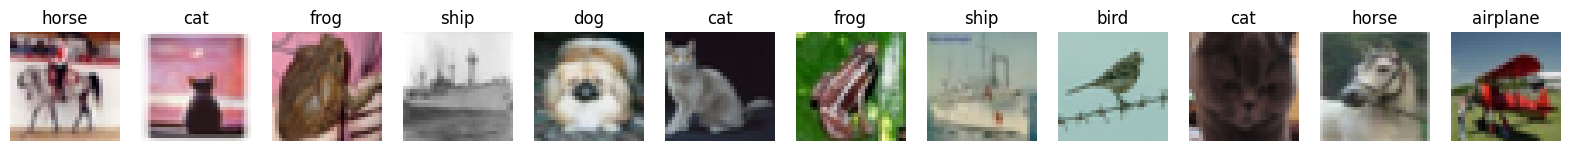

In [11]:
i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image, label in train_dataset.take(n_plots):  # Only take a single example
  axarr[i].imshow(image[0,:,:,:]+0.5)
  axarr[i].axis('off')
  axarr[i].title.set_text(label_str[int(label[0])])
  i = i+1



# 3. Model Coding

In this section You may develop your own model architecture to perform image recognition with the CIFAR-10 Dataset.

In the code cell below, an incomplete skeleton function is provided for your top level.  
* This uses the Keras functional API
* You can add your own layers/repeating units etc to build your own architecture within the function.
* Common Keras Layers:
 * Convolutional Layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
 * [Average Pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D) & [Max Pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPooling2D)
 * [Global Average Pooling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D)
 * Activation layers are described [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation)

* You may also improve the performance of your architecture during training using any of the various regularisation methods available in Keras:
 * [L1 & L2 Regularisation](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/Regularizer)
 * [Dropout Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)
 * [Spatial Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SpatialDropout2D)
 * Data Augmentation Layers, E.g. [RandomFlip](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip), [RandomZoom](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomCrop). See [Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) tutorial for usage example.
 * [Batch Normalisation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization)

Please Leave a note at the end of the notebook explaining your approach/results for the e-moderator.

In [ ]:

def network_top(input_shape,num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset
    model:       keras Model returned by this function.
    """

    """
    I have the following major takeways from my study of the state-of-the-art
    existing image classification models.
    - Increase the number of filters as we increase the a network's depth.
    - Decrease the filter size as we increase a network's depth.
    - Maxpooling is usually better than average pooling
    - Use of dropout regularization b/w fully connected layers
    - Stack mulitple convolution layers together with small filters and apply
      Maxpooling with the same stride.
    - Use multiple stacks of convolution and maxpooling layers
    - Use mulitple fully-connected layer, and in between them use Dropouts
    """

    """
    Based on the above my first model will comprise of the following:
    - Stack of convolution layers culminating with a MaxPooling layer
    - Deeper stack will have higher number of filters
    - Size of filter will be relatively large in fthe irst stack of the convolution layer
    - Three stacks of convolution and MaxPooling layers
    - Three fully connected layers with relatively large number of neurons
    - Between first and second dense layer there will be a Dropout layer for regularization
    """

    # Define input of model
    inputs = Input(shape=input_shape)

    #rescale = Rescaling(scale = 1./255)(inputs)

    conv1_1 = Conv2D(32, (5, 5), padding = "same", activation = "relu")(inputs)
    conv1_2 = Conv2D(16, (1, 1), padding = "same", activation = "relu")(conv1_1)
    conv1_3 = Conv2D(32, (3, 3), padding = "same", activation = "relu")(conv1_2)
    maxpolling1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv1_3)

    conv2_1 = Conv2D(64, (3, 3), padding = "same", activation = "relu")(maxpolling1)
    conv2_2 = Conv2D(48, (1, 1), padding = "same", activation = "relu")(conv2_1)
    conv2_3 = Conv2D(64, (3, 3), padding = "same", activation = "relu")(conv2_2)
    maxpolling2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv2_3)

    conv3_1 = Conv2D(128, (3, 3), padding = "same", activation = "relu")(maxpolling2)
    conv3_2 = Conv2D(64, (1, 1), padding = "same", activation = "relu")(conv3_1)
    conv3_3 = Conv2D(128, (3, 3), padding = "same", activation = "relu")(conv3_2)
    maxpolling3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv3_3)

    flat_layer = Flatten()(maxpolling3)

    # Here, Desne layers will be added for classification purpose
    dense1 = Dense(256, activation = "relu")(flat_layer)
    dropout_layer = Dropout(0.2)(dense1)
    dense2 = Dense(512, activation = "relu")(dropout_layer)
    outputs = Dense(num_classes, activation = "softmax")(dense2)

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    return model

# 4. Compile the Model
Now that we have defined our functions to create the model, we'll instantiate the model and compile it.  Note that the compiling step in Keras, also configures the model for training. We define  loss function, the optimizer and metrics.

Note the use here of [Sparse Categorical Crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy). This loss function allows us to input integer values for true classes. With the regular categorical cross entropy loss function the supplied labels must be frist converted to a one-hot representation,  but this special loss function allows us to avoid manually converting to the one-hot representation.

We will use the python package net_flops to estimate the computatational load of the model. Typically


In [ ]:
# Compile Model
input_shape = (32,32,3)
model = network_top(input_shape=input_shape)
model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(), metrics=['accuracy'])
# Obtain summary containing number of paramters
model.summary()
# Obtain summary of floating point operations in network
net_flops(model,table=True)

# Uncomment the following line to plot the model visually - warning this may be quite large!
# keras.utils.plot_model(model, dpi=48)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 16)        528       
                                                                 
 conv2d_32 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 16, 16, 64)        18496     
                                                           

# 5. Model Training

We will now train the complied model on the cifar10 dataset using the tensorflow keras `model.fit` method.

Note that the number of epochs is set to a high number, you may not require this many epochs to train your network. [Early Stopping](https://keras.io/api/callbacks/early_stopping/) has been included to stop training once validation loss stops improving. You may wish to adjust the paramters (such as start_from_epoch) to suit your particular architecture.


In [ ]:
# Set max training epochs
epochs =55
# Enable callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3,start_from_epoch=10)
# Train Model
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,callbacks=[callback])

Epoch 1/55
1407/1407 [==============================] - 18s 9ms/step - loss: 1.6532 - accuracy: 0.3820 - val_loss: 1.3716 - val_accuracy: 0.4822
Epoch 2/55
1407/1407 [==============================] - 13s 9ms/step - loss: 1.2752 - accuracy: 0.5395 - val_loss: 1.1277 - val_accuracy: 0.6000
Epoch 3/55
1407/1407 [==============================] - 14s 10ms/step - loss: 1.0562 - accuracy: 0.6244 - val_loss: 1.0041 - val_accuracy: 0.6431
Epoch 4/55
1407/1407 [==============================] - 13s 9ms/step - loss: 0.9029 - accuracy: 0.6816 - val_loss: 0.9495 - val_accuracy: 0.6782
Epoch 5/55
1407/1407 [==============================] - 13s 9ms/step - loss: 0.7878 - accuracy: 0.7217 - val_loss: 0.9370 - val_accuracy: 0.6844
Epoch 6/55
1407/1407 [==============================] - 13s 9ms/step - loss: 0.7066 - accuracy: 0.7491 - val_loss: 0.9736 - val_accuracy: 0.6778
Epoch 7/55
1407/1407 [==============================] - 13s 9ms/step - loss: 0.6323 - accuracy: 0.7740 - val_loss: 0.9884 - val_a

We will plot the loss and accuracy for the training and validation data sets.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


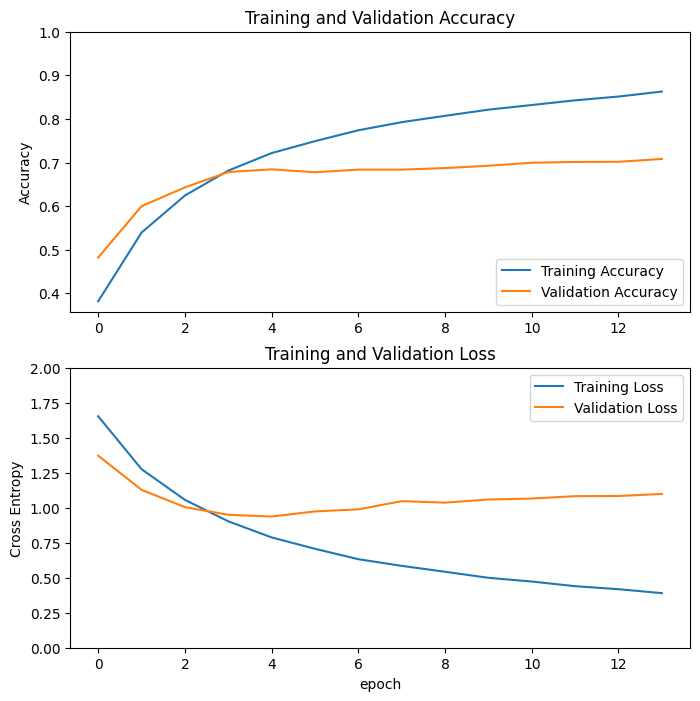

In [ ]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# 6. Model Testing
We will iterate through the test data and analyse the results using tools from sklearn. We create a classification report, a confusion matrix and also plot a few examples from the test set.

Iterate through n_test batches and store the predicted and ground truth labels in numpy arrays.

In [ ]:
n_test = 100 # number of batches to use
store_predictions = []
store_labels = []
for image_batch,label_batch in test_dataset.take(n_test):
    predictions = model.predict_on_batch(image_batch)
    predictions = tf.math.argmax(predictions,axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))


Create and plot a confusion matrix.

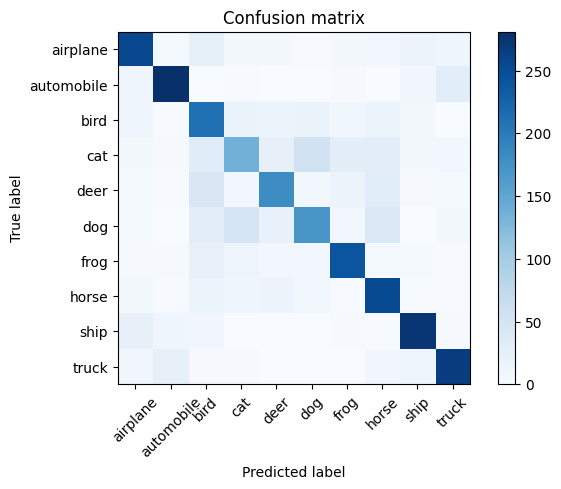

In [ ]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

Generate & print the classification report

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

              precision    recall  f1-score   support

    airplane       0.78      0.76      0.77       337
  automobile       0.85      0.83      0.84       338
        bird       0.54      0.69      0.61       306
         cat       0.56      0.42      0.48       323
        deer       0.67      0.61      0.64       297
         dog       0.64      0.52      0.58       325
        frog       0.76      0.79      0.77       307
       horse       0.65      0.79      0.71       317
        ship       0.83      0.84      0.83       326
       truck       0.80      0.82      0.81       324

    accuracy                           0.71      3200
   macro avg       0.71      0.71      0.70      3200
weighted avg       0.71      0.71      0.70      3200



Plot some test images and predicted labels.

(32, 10)
(32,)
Predictions:
 [2 0 6 9 2 1 7 0 3 7 7 2 7 9 2 7 2 8 7 9 4 2 7 5 2 0 6 8 1 8 6 0]


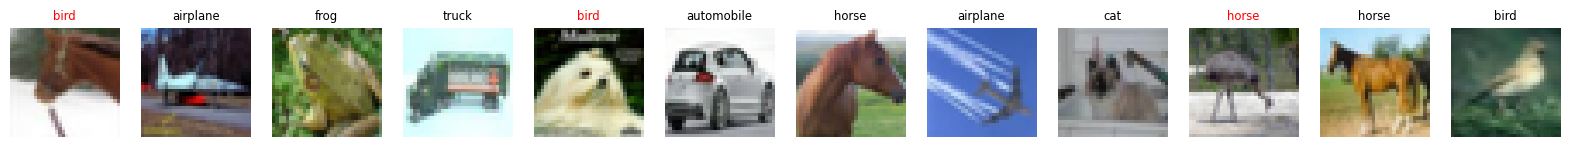

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print(np.shape(predictions))
# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,axis=1)
print(np.shape(predictions))
print('Predictions:\n', predictions.numpy())


i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:  # Only take a single example
  axarr[i].imshow(image[:,:,:]+0.5)
  axarr[i].axis('off')

  color = ('black' if predictions[i] == int(label_batch[i]) else 'red')
  axarr[i].set_title(label_str[int(predictions[i])],fontsize='small', color=color)
  i = i+1

# Takeawys from the first model


1.   The model is overfitting, hence we need more regularization as the validation accuracy is lower than the training accuracy
2.   The same has been demonstrated by the cross-entropy metric.

# Modifications to the Model


1.   Now, I will try more dropout layers to improve regularization






In [ ]:
def network_top(input_shape,num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset
    model:       keras Model returned by this function.
    """

    """
    I have the following major takeways from my study of the state-of-the-art
    existing image classification models.
    - Increase the number of filters as we increase the a network's depth.
    - Decrease the filter size as we increase a network's depth.
    - Maxpooling is usually better than average pooling
    - Use of dropout regularization b/w fully connected layers
    - Stack mulitple convolution layers together with small filters and apply
      Maxpooling with the same stride.
    - Use multiple stacks of convolution and maxpooling layers
    - Use mulitple fully-connected layer, and in between them use Dropouts
    """

    """
    Based on the above my first model will comprise of the following:
    - Stack of convolution layers culminating with a MaxPooling layer
    - Deeper stack will have higher number of filters
    - Size of filter will be relatively large in fthe irst stack of the convolution layer
    - Three stacks of convolution and MaxPooling layers
    - Three fully connected layers with relatively large number of neurons
    - Between first and second dense layer there will be a Dropout layer for regularization
    - In the modified mode, I am now adding dropout layers between the stack of convolution and max pooling layers
    """

    # Define input of model
    inputs = Input(shape=input_shape)

    #rescale = Rescaling(scale = 1./255)(inputs)

    conv1_1 = Conv2D(32, (5, 5), padding = "same", activation = "relu")(inputs)
    conv1_2 = Conv2D(16, (1, 1), padding = "same", activation = "relu")(conv1_1)
    conv1_3 = Conv2D(32, (3, 3), padding = "same", activation = "relu")(conv1_2)
    maxpolling1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv1_3)
    dropout_m_1 = Dropout(0.2)(maxpolling1)

    conv2_1 = Conv2D(64, (3, 3), padding = "same", activation = "relu")(dropout_m_1)
    conv2_2 = Conv2D(48, (1, 1), padding = "same", activation = "relu")(conv2_1)
    conv2_3 = Conv2D(64, (3, 3), padding = "same", activation = "relu")(conv2_2)
    maxpolling2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv2_3)
    dropout_m_2 = Dropout(0.2)(maxpolling2)

    conv3_1 = Conv2D(128, (3, 3), padding = "same", activation = "relu")(dropout_m_2)
    conv3_2 = Conv2D(64, (1, 1), padding = "same", activation = "relu")(conv3_1)
    conv3_3 = Conv2D(128, (3, 3), padding = "same", activation = "relu")(conv3_2)
    maxpolling3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv3_3)
    dropout_m_3 = Dropout(0.2)(maxpolling3)

    flat_layer = Flatten()(dropout_m_3)

    # Here, Desne layers will be added for classification purpose
    dense1 = Dense(256, activation = "relu")(flat_layer)
    dropout_layer = Dropout(0.2)(dense1)
    dense2 = Dense(512, activation = "relu")(dropout_layer)
    outputs = Dense(num_classes, activation = "softmax")(dense2)

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Compiling Modified Model

In [ ]:
# Compile Model
input_shape = (32,32,3)
model = network_top(input_shape=input_shape)
model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(), metrics=['accuracy'])
# Obtain summary containing number of paramters
model.summary()
# Obtain summary of floating point operations in network
net_flops(model,table=True)

# Uncomment the following line to plot the model visually - warning this may be quite large!
# keras.utils.plot_model(model, dpi=48)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_39 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 conv2d_40 (Conv2D)          (None, 32, 32, 16)        528       
                                                                 
 conv2d_41 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                           

# Training the Modified Model

In [ ]:
 # Set max training epochs
epochs =55
# Enable callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3,start_from_epoch=10)
# Train Model
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,callbacks=[callback])

Epoch 1/55
1407/1407 [==============================] - 19s 9ms/step - loss: 1.7344 - accuracy: 0.3505 - val_loss: 1.4206 - val_accuracy: 0.4736
Epoch 2/55
1407/1407 [==============================] - 13s 9ms/step - loss: 1.3512 - accuracy: 0.5046 - val_loss: 1.2150 - val_accuracy: 0.5556
Epoch 3/55
1407/1407 [==============================] - 13s 9ms/step - loss: 1.1500 - accuracy: 0.5895 - val_loss: 1.0392 - val_accuracy: 0.6238
Epoch 4/55
1407/1407 [==============================] - 13s 9ms/step - loss: 1.0223 - accuracy: 0.6395 - val_loss: 0.9516 - val_accuracy: 0.6571
Epoch 5/55
1407/1407 [==============================] - 13s 9ms/step - loss: 0.9347 - accuracy: 0.6705 - val_loss: 0.8851 - val_accuracy: 0.6822
Epoch 6/55
1407/1407 [==============================] - 12s 9ms/step - loss: 0.8658 - accuracy: 0.6962 - val_loss: 0.8231 - val_accuracy: 0.7024
Epoch 7/55
1407/1407 [==============================] - 12s 9ms/step - loss: 0.8153 - accuracy: 0.7132 - val_loss: 0.8006 - val_ac

# Plotting loss and accuracy of training and validation data sets.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


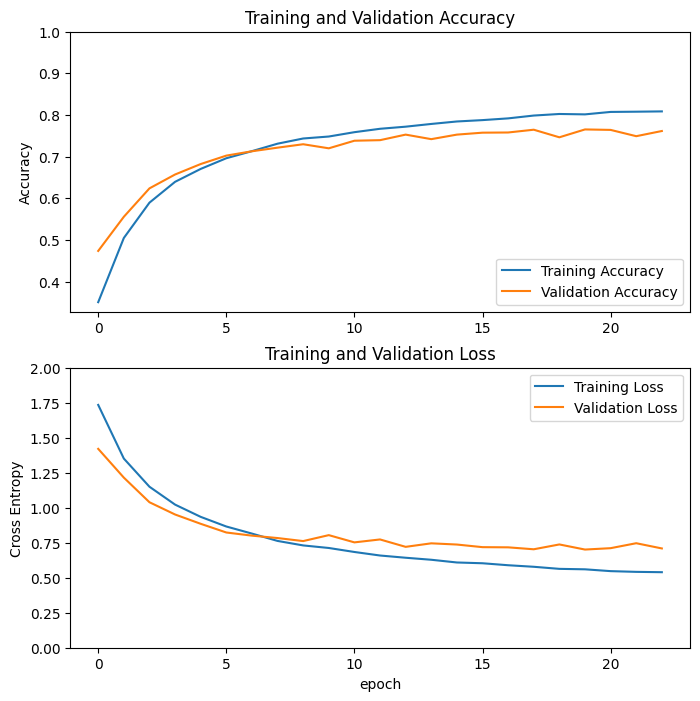

In [ ]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
n_test = 100 # number of batches to use
store_predictions = []
store_labels = []
for image_batch,label_batch in test_dataset.take(n_test):
    predictions = model.predict_on_batch(image_batch)
    predictions = tf.math.argmax(predictions,axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))

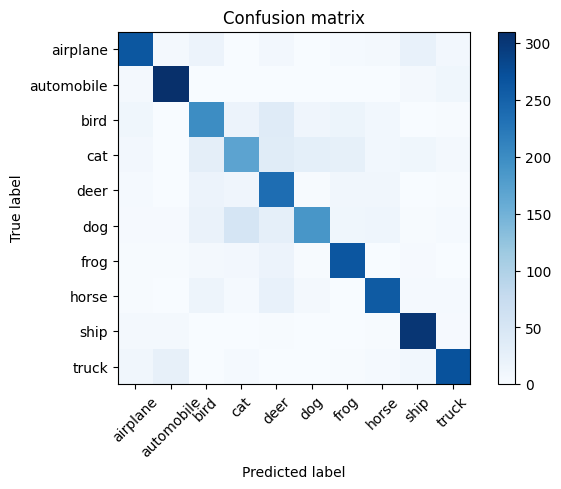

In [ ]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

              precision    recall  f1-score   support

    airplane       0.83      0.78      0.81       337
  automobile       0.87      0.92      0.89       338
        bird       0.65      0.65      0.65       306
         cat       0.63      0.52      0.57       323
        deer       0.61      0.80      0.69       297
         dog       0.79      0.58      0.66       325
        frog       0.79      0.86      0.82       307
       horse       0.82      0.81      0.82       317
        ship       0.83      0.93      0.88       326
       truck       0.87      0.83      0.85       324

    accuracy                           0.77      3200
   macro avg       0.77      0.77      0.76      3200
weighted avg       0.77      0.77      0.77      3200



(32, 10)
(32,)
Predictions:
 [2 1 6 9 5 1 7 0 7 4 7 2 7 9 2 7 2 8 7 9 4 2 3 5 0 8 2 8 1 8 6 0]


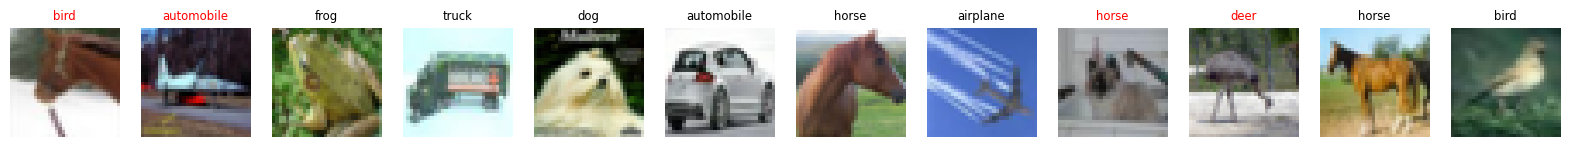

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print(np.shape(predictions))
# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,axis=1)
print(np.shape(predictions))
print('Predictions:\n', predictions.numpy())


i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:  # Only take a single example
  axarr[i].imshow(image[:,:,:]+0.5)
  axarr[i].axis('off')

  color = ('black' if predictions[i] == int(label_batch[i]) else 'red')
  axarr[i].set_title(label_str[int(predictions[i])],fontsize='small', color=color)
  i = i+1

# Takeaways from the Results Demonstrated by the Modified Model

The first model was demonstarting overfitting, hence there was a need to add regularization. Therefore, in the modified model I have added three more dropout layers between the stack of convolution and max pooling layers. The results demonstrated by the modified model does show that the modified model has less overfitting compared to the previous model, however it still demonstrates some overfitting. The model accuray has increased to 77% on test data, which is also nearly 10% percent better than the previous model.

Although the modified model demonstrates performance improvement, but still there is a room for improvement. Hence, I will try to further enhance the model by incorporation batch normilization as it can add regularization, speed up learning, and can also enhance network performance.

# Modified Model with Batch Normalization

In [ ]:
def network_top(input_shape,num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset
    model:       keras Model returned by this function.
    """

    """
    I have the following major takeways from my study of the state-of-the-art
    existing image classification models.
    - Increase the number of filters as we increase the a network's depth.
    - Decrease the filter size as we increase a network's depth.
    - Maxpooling is usually better than average pooling
    - Use of dropout regularization b/w fully connected layers
    - Stack mulitple convolution layers together with small filters and apply
      Maxpooling with the same stride.
    - Use multiple stacks of convolution and maxpooling layers
    - Use mulitple fully-connected layer, and in between them use Dropouts
    """

    """
    Based on the above my first model will comprise of the following:
    - Stack of convolution layers culminating with a MaxPooling layer
    - Deeper stack will have higher number of filters
    - Size of filter will be relatively large in fthe irst stack of the convolution layer
    - Three stacks of convolution and MaxPooling layers
    - Three fully connected layers with relatively large number of neurons
    - Between first and second dense layer there will be a Dropout layer for regularization
    - In the modified mode, I am now adding BatchNormalization
    """

    # Define input of model
    inputs = Input(shape=input_shape)

    #rescale = Rescaling(scale = 1./255)(inputs)

    conv1_1 = Conv2D(32, (5, 5), padding = "same", activation = "relu")(inputs)
    batch_norm1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(16, (1, 1), padding = "same", activation = "relu")(batch_norm1_1)
    batch_norm1_2 = BatchNormalization()(conv1_2)
    conv1_3 = Conv2D(32, (3, 3), padding = "same", activation = "relu")(batch_norm1_2)
    maxpolling1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv1_3)
    dropout_m_1 = Dropout(0.2)(maxpolling1)
    batch_norm_1_3 = BatchNormalization()(dropout_m_1)

    conv2_1 = Conv2D(64, (3, 3), padding = "same", activation = "relu")(batch_norm_1_3)
    batch_norm_2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(48, (1, 1), padding = "same", activation = "relu")(batch_norm_2_1)
    batch_norm_2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(64, (3, 3), padding = "same", activation = "relu")(batch_norm_2_2)
    maxpolling2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv2_3)
    dropout_m_2 = Dropout(0.2)(maxpolling2)
    batch_norm_2_3 = BatchNormalization()(dropout_m_2)

    conv3_1 = Conv2D(128, (3, 3), padding = "same", activation = "relu")(batch_norm_2_3)
    batch_norm_3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(64, (1, 1), padding = "same", activation = "relu")(batch_norm_3_1)
    batch_norm_3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(128, (3, 3), padding = "same", activation = "relu")(batch_norm_3_2)
    maxpolling3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv3_3)
    dropout_m_3 = Dropout(0.2)(maxpolling3)
    batch_norm_3_2 = BatchNormalization()(dropout_m_3 )

    flat_layer = Flatten()(batch_norm_3_2)

    # Here, Desne layers will be added for classification purpose
    dense1 = Dense(256, activation = "relu")(flat_layer)
    dropout_layer = Dropout(0.2)(dense1)
    batch_norm_d_1 = BatchNormalization()(dropout_layer)
    dense2 = Dense(512, activation = "relu")(batch_norm_d_1)
    batch_norm_d_2 = BatchNormalization()(dense2)
    outputs = Dense(num_classes, activation = "softmax")(batch_norm_d_2 )

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Compile the Model with BatchNormalization

In [ ]:
# Compile Model
input_shape = (32,32,3)
model = network_top(input_shape=input_shape)
model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(), metrics=['accuracy'])
# Obtain summary containing number of paramters
model.summary()
# Obtain summary of floating point operations in network
net_flops(model,table=True)

# Uncomment the following line to plot the model visually - warning this may be quite large!
# keras.utils.plot_model(model, dpi=48)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_49 (Conv2D)          (None, 32, 32, 16)        528       
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_50 (Conv2D)          (None, 32, 32, 32)        4640

# Training the Model with BatchNormalization

In [ ]:
 # Set max training epochs
epochs =55
# Enable callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3,start_from_epoch=10)
# Train Model
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,callbacks=[callback])

Epoch 1/55
1407/1407 [==============================] - 29s 14ms/step - loss: 1.5945 - accuracy: 0.4348 - val_loss: 1.2122 - val_accuracy: 0.5538
Epoch 2/55
1407/1407 [==============================] - 20s 14ms/step - loss: 1.1348 - accuracy: 0.6002 - val_loss: 0.8751 - val_accuracy: 0.6862
Epoch 3/55
1407/1407 [==============================] - 19s 14ms/step - loss: 0.9291 - accuracy: 0.6731 - val_loss: 0.7883 - val_accuracy: 0.7169
Epoch 4/55
1407/1407 [==============================] - 20s 14ms/step - loss: 0.8032 - accuracy: 0.7190 - val_loss: 0.7265 - val_accuracy: 0.7467
Epoch 5/55
1407/1407 [==============================] - 20s 14ms/step - loss: 0.7092 - accuracy: 0.7522 - val_loss: 0.6776 - val_accuracy: 0.7600
Epoch 6/55
1407/1407 [==============================] - 20s 14ms/step - loss: 0.6360 - accuracy: 0.7786 - val_loss: 0.6297 - val_accuracy: 0.7864
Epoch 7/55
1407/1407 [==============================] - 20s 14ms/step - loss: 0.5737 - accuracy: 0.8001 - val_loss: 0.6016 -

# Plotting Loss and Accuracy of the Model

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


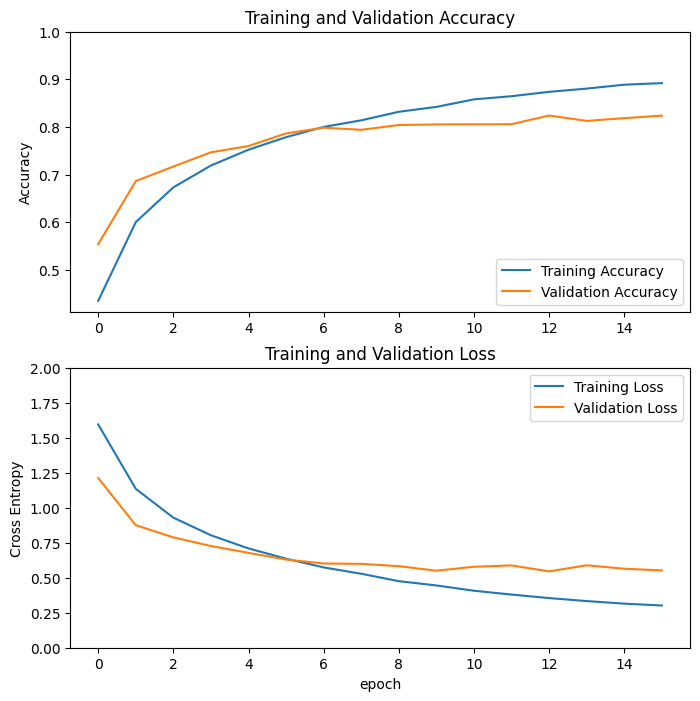

In [ ]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
n_test = 100 # number of batches to use
store_predictions = []
store_labels = []
for image_batch,label_batch in test_dataset.take(n_test):
    predictions = model.predict_on_batch(image_batch)
    predictions = tf.math.argmax(predictions,axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))

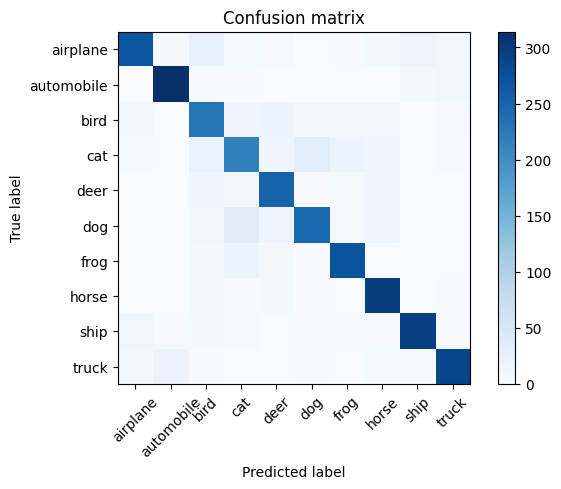

In [ ]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

              precision    recall  f1-score   support

    airplane       0.90      0.80      0.84       337
  automobile       0.92      0.93      0.92       338
        bird       0.71      0.75      0.73       306
         cat       0.71      0.67      0.69       323
        deer       0.79      0.85      0.82       297
         dog       0.81      0.75      0.78       325
        frog       0.87      0.89      0.88       307
       horse       0.82      0.94      0.88       317
        ship       0.92      0.90      0.91       326
       truck       0.91      0.89      0.90       324

    accuracy                           0.84      3200
   macro avg       0.84      0.84      0.84      3200
weighted avg       0.84      0.84      0.84      3200



(32, 10)
(32,)
Predictions:
 [7 1 6 9 7 1 7 0 3 4 7 2 7 9 2 7 2 8 7 9 4 5 3 5 0 8 2 8 1 8 2 0]


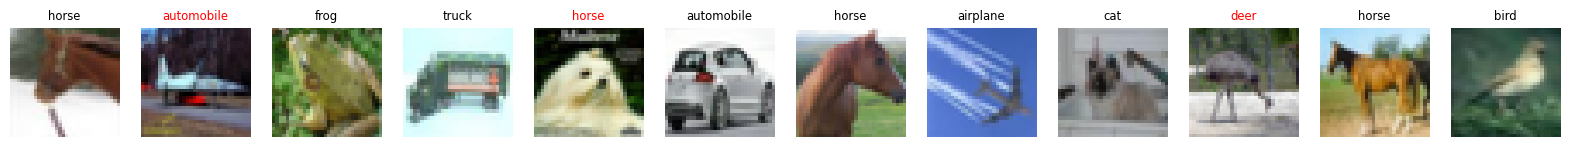

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
print(np.shape(predictions))
# Apply a sigmoid since our model returns logits
predictions = tf.math.argmax(predictions,axis=1)
print(np.shape(predictions))
print('Predictions:\n', predictions.numpy())


i=0
n_plots = 12 # number of plots
f, axarr = plt.subplots(1,n_plots,figsize=(20,10))

for image in image_batch[0:n_plots,:,:,:]:  # Only take a single example
  axarr[i].imshow(image[:,:,:]+0.5)
  axarr[i].axis('off')

  color = ('black' if predictions[i] == int(label_batch[i]) else 'red')
  axarr[i].set_title(label_str[int(predictions[i])],fontsize='small', color=color)
  i = i+1

# Another Model with Data Augmentation

In [ ]:
def network_top(input_shape,num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset
    model:       keras Model returned by this function.
    """

    """
    I have the following major takeways from my study of the state-of-the-art
    existing image classification models.
    - Increase the number of filters as we increase the a network's depth.
    - Decrease the filter size as we increase a network's depth.
    - Maxpooling is usually better than average pooling
    - Use of dropout regularization b/w fully connected layers
    - Stack mulitple convolution layers together with small filters and apply
      Maxpooling with the same stride.
    - Use multiple stacks of convolution and maxpooling layers
    - Use mulitple fully-connected layer, and in between them use Dropouts
    """

    """
    Based on the above my first model will comprise of the following:
    - Stack of convolution layers culminating with a MaxPooling layer
    - Deeper stack will have higher number of filters
    - Size of filter will be relatively large in fthe irst stack of the convolution layer
    - Three stacks of convolution and MaxPooling layers
    - Three fully connected layers with relatively large number of neurons
    - Between first and second dense layer there will be a Dropout layer for regularization
    - In the modified mode, I am now adding data augmentation
    """

    # Define input of model
    inputs = Input(shape=input_shape)

    # Data augmentation layers
    random_flip = RandomFlip('horizontal')(inputs)

    random_rotate = RandomRotation(0.20)(random_flip)

    random_translation = RandomTranslation(height_factor=0.2, width_factor=0.2)(random_rotate)

    conv1_1 = Conv2D(32, (5, 5), padding = "same", activation = "relu")(random_translation)
    batch_norm1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(16, (1, 1), padding = "same", activation = "relu")(batch_norm1_1)
    batch_norm1_2 = BatchNormalization()(conv1_2)
    conv1_3 = Conv2D(32, (3, 3), padding = "same", activation = "relu")(batch_norm1_2)
    maxpolling1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv1_3)
    dropout_m_1 = Dropout(0.2)(maxpolling1)
    batch_norm_1_3 = BatchNormalization()(dropout_m_1)

    conv2_1 = Conv2D(64, (3, 3), padding = "same", activation = "relu")(batch_norm_1_3)
    batch_norm_2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(48, (1, 1), padding = "same", activation = "relu")(batch_norm_2_1)
    batch_norm_2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(64, (3, 3), padding = "same", activation = "relu")(batch_norm_2_2)
    maxpolling2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv2_3)
    dropout_m_2 = Dropout(0.2)(maxpolling2)
    batch_norm_2_3 = BatchNormalization()(dropout_m_2)

    conv3_1 = Conv2D(128, (3, 3), padding = "same", activation = "relu")(batch_norm_2_3)
    batch_norm_3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(64, (1, 1), padding = "same", activation = "relu")(batch_norm_3_1)
    batch_norm_3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(128, (3, 3), padding = "same", activation = "relu")(batch_norm_3_2)
    maxpolling3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv3_3)
    dropout_m_3 = Dropout(0.2)(maxpolling3)
    batch_norm_3_2 = BatchNormalization()(dropout_m_3 )

    flat_layer = Flatten()(batch_norm_3_2)

    # Here, Desne layers will be added for classification purpose
    dense1 = Dense(256, activation = "relu")(flat_layer)
    dropout_layer = Dropout(0.2)(dense1)
    batch_norm_d_1 = BatchNormalization()(dropout_layer)
    dense2 = Dense(512, activation = "relu")(batch_norm_d_1)
    batch_norm_d_2 = BatchNormalization()(dense2)
    outputs = Dense(num_classes, activation = "softmax")(batch_norm_d_2 )

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Compile the Model

In [ ]:
# Compile Model
input_shape = (32,32,3)
model = network_top(input_shape=input_shape)
model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(), metrics=['accuracy'])
# Obtain summary containing number of paramters
model.summary()
# Obtain summary of floating point operations in network
net_flops(model,table=True)

# Uncomment the following line to plot the model visually - warning this may be quite large!
# keras.utils.plot_model(model, dpi=48)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 random_flip (RandomFlip)    (None, 32, 32, 3)         0         
                                                                 
 random_rotation (RandomRot  (None, 32, 32, 3)         0         
 ation)                                                          
                                                                 
 random_translation (Random  (None, 32, 32, 3)         0         
 Translation)                                                    
                                                                 
 conv2d_57 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 batch_normalization_11 (Ba  (None, 32, 32, 32)        128 

# Training the Model

In [ ]:
# Set max training epochs
epochs =55
# Enable callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3,start_from_epoch=10)
# Train Model
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,callbacks=[callback])

Epoch 1/55
1407/1407 [==============================] - 31s 15ms/step - loss: 1.9682 - accuracy: 0.2997 - val_loss: 1.6800 - val_accuracy: 0.3978
Epoch 2/55
1407/1407 [==============================] - 22s 15ms/step - loss: 1.7159 - accuracy: 0.3798 - val_loss: 1.4542 - val_accuracy: 0.4693
Epoch 3/55
1407/1407 [==============================] - 22s 15ms/step - loss: 1.5852 - accuracy: 0.4274 - val_loss: 1.4437 - val_accuracy: 0.4862
Epoch 4/55
1407/1407 [==============================] - 22s 16ms/step - loss: 1.4863 - accuracy: 0.4623 - val_loss: 1.4203 - val_accuracy: 0.5036
Epoch 5/55
1407/1407 [==============================] - 22s 15ms/step - loss: 1.3996 - accuracy: 0.5006 - val_loss: 1.1566 - val_accuracy: 0.5818
Epoch 6/55
1407/1407 [==============================] - 22s 16ms/step - loss: 1.3276 - accuracy: 0.5265 - val_loss: 1.1622 - val_accuracy: 0.5891
Epoch 7/55
1407/1407 [==============================] - 24s 17ms/step - loss: 1.2682 - accuracy: 0.5521 - val_loss: 1.1356 -

# Plotting Loss and Accuracy of the Model

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


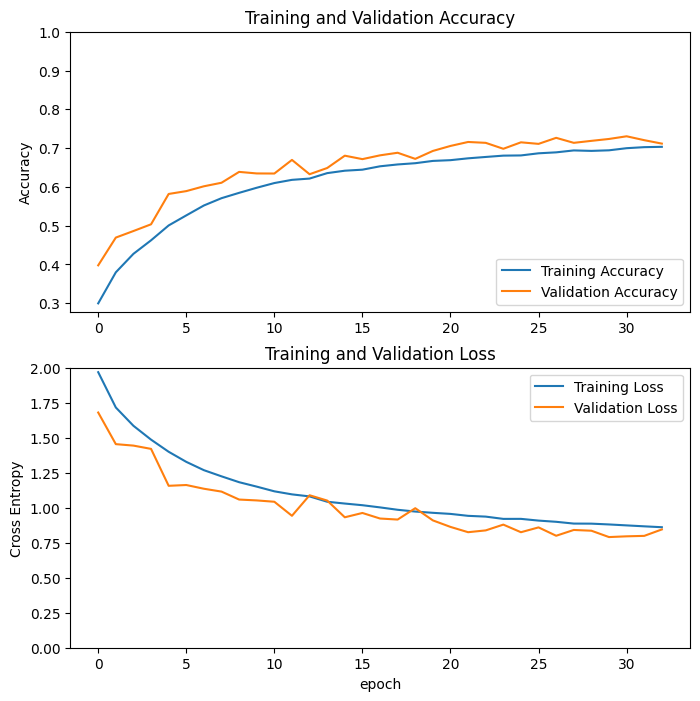

In [ ]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
n_test = 100 # number of batches to use
store_predictions = []
store_labels = []
for image_batch,label_batch in test_dataset.take(n_test):
    predictions = model.predict_on_batch(image_batch)
    predictions = tf.math.argmax(predictions,axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))

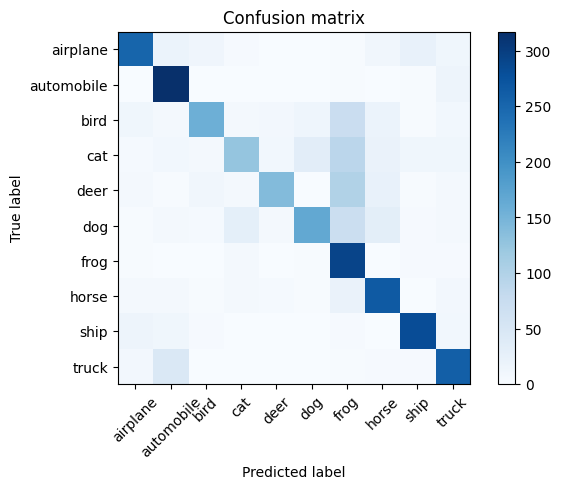

In [ ]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

              precision    recall  f1-score   support

    airplane       0.81      0.75      0.78       337
  automobile       0.75      0.94      0.83       338
        bird       0.80      0.51      0.62       306
         cat       0.69      0.39      0.50       323
        deer       0.82      0.47      0.60       297
         dog       0.76      0.51      0.61       325
        frog       0.45      0.95      0.61       307
       horse       0.71      0.84      0.77       317
        ship       0.85      0.87      0.86       326
       truck       0.76      0.80      0.78       324

    accuracy                           0.70      3200
   macro avg       0.74      0.70      0.70      3200
weighted avg       0.74      0.70      0.70      3200



# Remarks
The model with data augmentation doesn't produce good results, in fact it demonstrates worse results compared to the previous model that has demonstarted accuracy, recall, and precision of 84%.

In [ ]:
def network_top(input_shape,num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset
    model:       keras Model returned by this function.
    """

    """
    I have the following major takeways from my study of the state-of-the-art
    existing image classification models.
    - Increase the number of filters as we increase the a network's depth.
    - Decrease the filter size as we increase a network's depth.
    - Maxpooling is usually better than average pooling
    - Use of dropout regularization b/w fully connected layers
    - Stack mulitple convolution layers together with small filters and apply
      Maxpooling with the same stride.
    - Use multiple stacks of convolution and maxpooling layers
    - Use mulitple fully-connected layer, and in between them use Dropouts
    """

    """
    Based on the above my first model will comprise of the following:
    - Stack of convolution layers culminating with a MaxPooling layer
    - Deeper stack will have higher number of filters
    - Size of filter will be relatively large in fthe irst stack of the convolution layer
    - Three stacks of convolution and MaxPooling layers
    - Three fully connected layers with relatively large number of neurons
    - Between first and second dense layer there will be a Dropout layer for regularization
    - In the modified model, I will replace 1*1 convolution with 3*3 and replace flatten layer
      with GlobalAveragePooling2D.
    """

    # Define input of model
    inputs = Input(shape=input_shape)

    #rescale = Rescaling(scale = 1./255)(inputs)

    conv1_1 = Conv2D(32, (5, 5), padding = "same", activation = "relu")(inputs)
    batch_norm1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(16, (3, 3), padding = "same", activation = "relu")(batch_norm1_1)
    batch_norm1_2 = BatchNormalization()(conv1_2)
    conv1_3 = Conv2D(32, (3, 3), padding = "same", activation = "relu")(batch_norm1_2)
    maxpolling1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv1_3)
    dropout_m_1 = Dropout(0.2)(maxpolling1)
    batch_norm_1_3 = BatchNormalization()(dropout_m_1)

    conv2_1 = Conv2D(64, (3, 3), padding = "same", activation = "relu")(batch_norm_1_3)
    batch_norm_2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(48, (3, 3), padding = "same", activation = "relu")(batch_norm_2_1)
    batch_norm_2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(64, (3, 3), padding = "same", activation = "relu")(batch_norm_2_2)
    maxpolling2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv2_3)
    dropout_m_2 = Dropout(0.2)(maxpolling2)
    batch_norm_2_3 = BatchNormalization()(dropout_m_2)

    conv3_1 = Conv2D(128, (3, 3), padding = "same", activation = "relu")(batch_norm_2_3)
    batch_norm_3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(64, (3, 3), padding = "same", activation = "relu")(batch_norm_3_1)
    batch_norm_3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(128, (3, 3), padding = "same", activation = "relu")(batch_norm_3_2)
    maxpolling3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv3_3)
    dropout_m_3 = Dropout(0.2)(maxpolling3)
    batch_norm_3_2 = BatchNormalization()(dropout_m_3 )

    global_average_pooling = GlobalAveragePooling2D()(batch_norm_3_2)

    # Here, Desne layers will be added for classification purpose
    dense1 = Dense(256, activation = "relu")(global_average_pooling)
    dropout_layer = Dropout(0.2)(dense1)
    batch_norm_d_1 = BatchNormalization()(dropout_layer)
    dense2 = Dense(512, activation = "relu")(batch_norm_d_1)
    batch_norm_d_2 = BatchNormalization()(dense2)
    outputs = Dense(num_classes, activation = "softmax")(batch_norm_d_2 )

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    return model

## Compile the Model

In [ ]:
# Compile Model
input_shape = (32,32,3)
model = network_top(input_shape=input_shape)
model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(), metrics=['accuracy'])
# Obtain summary containing number of paramters
model.summary()
# Obtain summary of floating point operations in network
net_flops(model,table=True)

# Uncomment the following line to plot the model visually - warning this may be quite large!
# keras.utils.plot_model(model, dpi=48)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_66 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 batch_normalization_22 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_67 (Conv2D)          (None, 32, 32, 16)        4624      
                                                                 
 batch_normalization_23 (Ba  (None, 32, 32, 16)        64        
 tchNormalization)                                               
                                                                 
 conv2d_68 (Conv2D)          (None, 32, 32, 32)        4640

# Train the Model

In [ ]:
# Set max training epochs
epochs =55
# Enable callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3,start_from_epoch=10)
# Train Model
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,callbacks=[callback])

Epoch 1/55
1407/1407 [==============================] - 31s 15ms/step - loss: 1.6392 - accuracy: 0.4088 - val_loss: 1.2565 - val_accuracy: 0.5524
Epoch 2/55
1407/1407 [==============================] - 21s 15ms/step - loss: 1.1646 - accuracy: 0.5865 - val_loss: 0.9425 - val_accuracy: 0.6604
Epoch 3/55
1407/1407 [==============================] - 20s 14ms/step - loss: 0.9532 - accuracy: 0.6672 - val_loss: 0.7985 - val_accuracy: 0.7211
Epoch 4/55
1407/1407 [==============================] - 20s 14ms/step - loss: 0.8094 - accuracy: 0.7182 - val_loss: 0.6845 - val_accuracy: 0.7598
Epoch 5/55
1407/1407 [==============================] - 21s 15ms/step - loss: 0.7132 - accuracy: 0.7547 - val_loss: 0.6757 - val_accuracy: 0.7669
Epoch 6/55
1407/1407 [==============================] - 20s 14ms/step - loss: 0.6314 - accuracy: 0.7836 - val_loss: 0.6006 - val_accuracy: 0.7949
Epoch 7/55
1407/1407 [==============================] - 20s 15ms/step - loss: 0.5732 - accuracy: 0.8028 - val_loss: 0.5962 -

## Plotting the Results

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


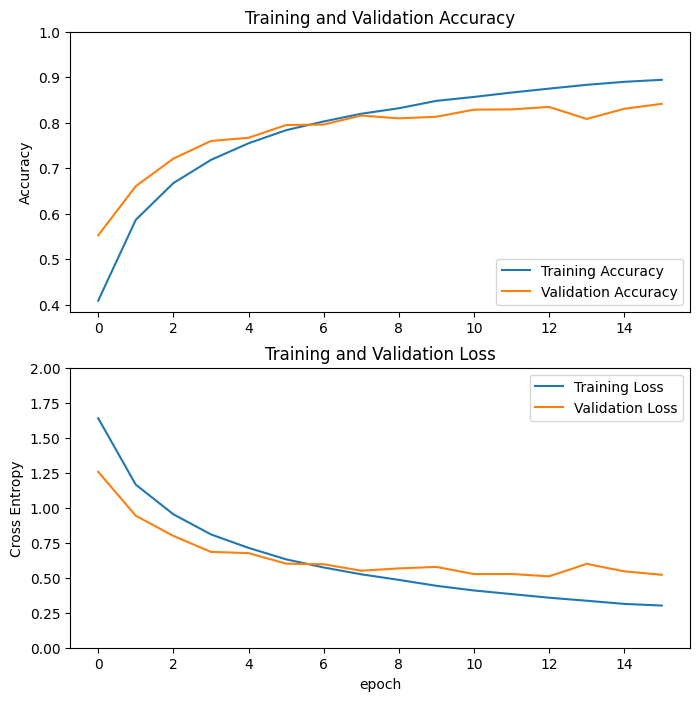

In [ ]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
n_test = 100 # number of batches to use
store_predictions = []
store_labels = []
for image_batch,label_batch in test_dataset.take(n_test):
    predictions = model.predict_on_batch(image_batch)
    predictions = tf.math.argmax(predictions,axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))

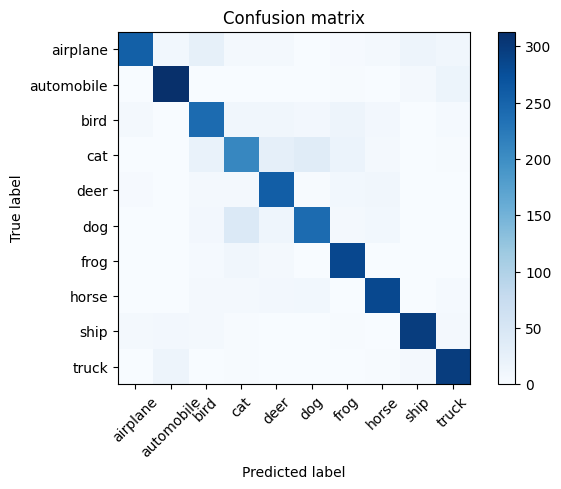

In [ ]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

              precision    recall  f1-score   support

    airplane       0.92      0.76      0.83       337
  automobile       0.90      0.93      0.91       338
        bird       0.76      0.79      0.77       306
         cat       0.71      0.65      0.68       323
        deer       0.78      0.87      0.82       297
         dog       0.81      0.74      0.77       325
        frog       0.83      0.93      0.88       307
       horse       0.87      0.89      0.88       317
        ship       0.91      0.91      0.91       326
       truck       0.87      0.92      0.89       324

    accuracy                           0.84      3200
   macro avg       0.84      0.84      0.84      3200
weighted avg       0.84      0.84      0.84      3200



In [12]:
def network_top(input_shape,num_classes=10):
    """
    input Shape: (Define H,W, no. channels) of network input
                 used in Input definition below
    num_classes: Default = 10, sets output classes of network,
                 set to same no. of classes as CIFAR 10 Dataset
    model:       keras Model returned by this function.
    """

    """
    I have the following major takeways from my study of the state-of-the-art
    existing image classification models.
    - Increase the number of filters as we increase the a network's depth.
    - Decrease the filter size as we increase a network's depth.
    - Maxpooling is usually better than average pooling
    - Use of dropout regularization b/w fully connected layers
    - Stack mulitple convolution layers together with small filters and apply
      Maxpooling with the same stride.
    - Use multiple stacks of convolution and maxpooling layers
    - Use mulitple fully-connected layer, and in between them use Dropouts
    """

    """
    Based on the above my first model will comprise of the following:
    - Stack of convolution layers culminating with a MaxPooling layer
    - Deeper stack will have higher number of filters
    - Size of filter will be relatively large in fthe irst stack of the convolution layer
    - Three stacks of convolution and MaxPooling layers
    - Three fully connected layers with relatively large number of neurons
    - Between first and second dense layer there will be a Dropout layer for regularization
    - In the modified model, I will replace 1*1 convolution with 3*3 and replace flatten layer
      with GlobalAveragePooling2D.
    """

    # Define input of model
    inputs = Input(shape=input_shape)

    #rescale = Rescaling(scale = 1./255)(inputs)

    conv1_1 = Conv2D(32, (5, 5), padding = "same", activation = "relu")(inputs)
    batch_norm1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(16, (3, 3), padding = "same", activation = "relu")(batch_norm1_1)
    batch_norm1_2 = BatchNormalization()(conv1_2)
    conv1_3 = Conv2D(32, (3, 3), padding = "same", activation = "relu")(batch_norm1_2)
    maxpolling1 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv1_3)
    dropout_m_1 = Dropout(0.2)(maxpolling1)
    batch_norm_1_3 = BatchNormalization()(dropout_m_1)

    conv2_1 = Conv2D(64, (3, 3), padding = "same", activation = "relu")(batch_norm_1_3)
    batch_norm_2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(48, (3, 3), padding = "same", activation = "relu")(batch_norm_2_1)
    batch_norm_2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(64, (3, 3), padding = "same", activation = "relu")(batch_norm_2_2)
    maxpolling2 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv2_3)
    dropout_m_2 = Dropout(0.2)(maxpolling2)
    batch_norm_2_3 = BatchNormalization()(dropout_m_2)

    conv3_1 = Conv2D(128, (3, 3), padding = "same", activation = "relu")(batch_norm_2_3)
    batch_norm_3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(64, (3, 3), padding = "same", activation = "relu")(batch_norm_3_1)
    batch_norm_3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(128, (3, 3), padding = "same", activation = "relu")(batch_norm_3_2)
    maxpolling3 = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(conv3_3)
    dropout_m_3 = Dropout(0.2)(maxpolling3)
    batch_norm_3_2 = BatchNormalization()(dropout_m_3 )

    flat_layer = Flatten()(batch_norm_3_2)

    # Here, Desne layers will be added for classification purpose
    dense1 = Dense(256, activation = "relu")(flat_layer)
    dropout_layer = Dropout(0.2)(dense1)
    batch_norm_d_1 = BatchNormalization()(dropout_layer)
    dense2 = Dense(512, activation = "relu")(batch_norm_d_1)
    batch_norm_d_2 = BatchNormalization()(dense2)
    outputs = Dense(num_classes, activation = "softmax")(batch_norm_d_2 )

    # Model definition
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [13]:
# Compile Model
input_shape = (32,32,3)
model = network_top(input_shape=input_shape)
model.compile(loss='SparseCategoricalCrossentropy', optimizer=Adam(), metrics=['accuracy'])
# Obtain summary containing number of paramters
model.summary()
# Obtain summary of floating point operations in network
net_flops(model,table=True)

# Uncomment the following line to plot the model visually - warning this may be quite large!
# keras.utils.plot_model(model, dpi=48)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 16)        64        
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640  

In [14]:
# Set max training epochs
epochs =55
# Enable callback for early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=3,start_from_epoch=10)
# Train Model
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,callbacks=[callback])

Epoch 1/55
1407/1407 [==============================] - 42s 18ms/step - loss: 1.6029 - accuracy: 0.4291 - val_loss: 1.1311 - val_accuracy: 0.5887
Epoch 2/55
1407/1407 [==============================] - 18s 13ms/step - loss: 1.0889 - accuracy: 0.6176 - val_loss: 0.8980 - val_accuracy: 0.6762
Epoch 3/55
1407/1407 [==============================] - 19s 13ms/step - loss: 0.8837 - accuracy: 0.6906 - val_loss: 0.7159 - val_accuracy: 0.7436
Epoch 4/55
1407/1407 [==============================] - 18s 13ms/step - loss: 0.7621 - accuracy: 0.7352 - val_loss: 0.6565 - val_accuracy: 0.7702
Epoch 5/55
1407/1407 [==============================] - 19s 14ms/step - loss: 0.6653 - accuracy: 0.7692 - val_loss: 0.5892 - val_accuracy: 0.7962
Epoch 6/55
1407/1407 [==============================] - 18s 13ms/step - loss: 0.5920 - accuracy: 0.7944 - val_loss: 0.5947 - val_accuracy: 0.7956
Epoch 7/55
1407/1407 [==============================] - 19s 13ms/step - loss: 0.5329 - accuracy: 0.8154 - val_loss: 0.5450 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


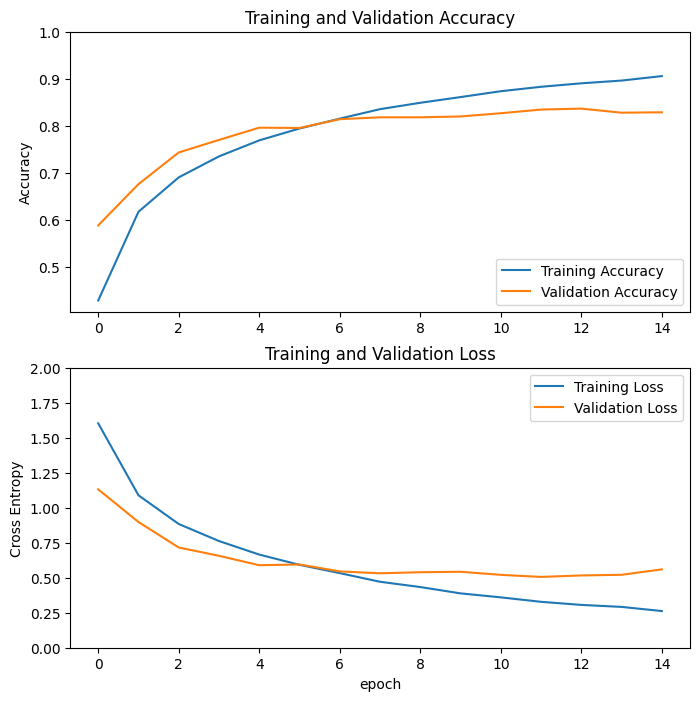

In [15]:
print(history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
n_test = 100 # number of batches to use
store_predictions = []
store_labels = []
for image_batch,label_batch in test_dataset.take(n_test):
    predictions = model.predict_on_batch(image_batch)
    predictions = tf.math.argmax(predictions,axis=1)
    store_predictions.append(predictions)
    store_labels.append(label_batch)
y_pred = np.squeeze(np.reshape(store_predictions,(1,n_test*batch_size)))
y_true = np.squeeze(np.reshape(store_labels,(1,n_test*batch_size)))

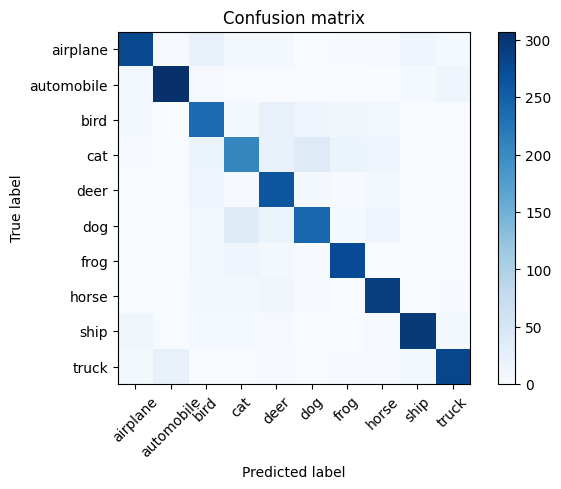

In [17]:
#https://scikit-learn.org/0.16/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_str))
    plt.xticks(tick_marks, label_str, rotation=45)
    plt.yticks(tick_marks, label_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label_str))

              precision    recall  f1-score   support

    airplane       0.88      0.82      0.85       337
  automobile       0.92      0.91      0.91       338
        bird       0.74      0.77      0.75       306
         cat       0.73      0.64      0.68       323
        deer       0.74      0.88      0.80       297
         dog       0.80      0.74      0.77       325
        frog       0.87      0.89      0.88       307
       horse       0.84      0.91      0.87       317
        ship       0.92      0.90      0.91       326
       truck       0.92      0.86      0.89       324

    accuracy                           0.83      3200
   macro avg       0.83      0.83      0.83      3200
weighted avg       0.84      0.83      0.83      3200



# Conclusion

The following positively impacts the performance, number of computations, and model parameters:


1.   Stack multiple convolution layers together with a relatively smaller kernel size.
2.   Use batch normalization between the convolution layers.
3. Between convolution stack use max pooling.
4. Use more filters as our network gets deep.
5. Use mulitple dense layers.
6. Use dropouts layers between stacked convolution layers, and dense layers.

The comparison of different modes I have presented here reveals that we can acheive 84% accuracy with a relatively lower number of operations and paramaters. Moeover, the results also demonstarte that augumentation is not useful for the problem at hand.



